In [1]:
import os
import shutil
import random
from glob import glob

# 1. Original Kaggle TB dataset root
orig_root = r"C://TB_Chest_Radiography_Database"  # change if needed
normal_dir = os.path.join(orig_root, "Normal")
tb_dir     = os.path.join(orig_root, "Tuberculosis")

# 2. New root with train/val/test split
new_root = r"C://tb_chest_xray"   # we'll point PyTorch here

splits = ["train", "val", "test"]
classes = ["NORMAL", "TUBERCULOSIS"]

# 3. Create folders
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(new_root, split, cls), exist_ok=True)

def split_and_copy(src_dir, cls_name):
    # All image paths in this class
    files = glob(os.path.join(src_dir, "*.*"))
    random.shuffle(files)

    n_total = len(files)
    n_train = int(0.7 * n_total)
    n_val   = int(0.15 * n_total)
    n_test  = n_total - n_train - n_val

    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    print(f"{cls_name}: total={n_total}, train={len(train_files)}, val={len(val_files)}, test={len(test_files)}")

    dest_train = os.path.join(new_root, "train", cls_name)
    dest_val   = os.path.join(new_root, "val",   cls_name)
    dest_test  = os.path.join(new_root, "test",  cls_name)

    for f in train_files:
        shutil.copy2(f, dest_train)
    for f in val_files:
        shutil.copy2(f, dest_val)
    for f in test_files:
        shutil.copy2(f, dest_test)

# 4. Split NORMAL and TB
split_and_copy(normal_dir, "NORMAL")
split_and_copy(tb_dir,     "TUBERCULOSIS")

print("✅ Done splitting TB dataset into train/val/test.")


NORMAL: total=3500, train=2450, val=525, test=525
TUBERCULOSIS: total=700, train=489, val=105, test=106
✅ Done splitting TB dataset into train/val/test.


In [3]:
import os
import time
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import timm

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ============================================================
# 1️⃣ Config
# ============================================================
# TODO: change this to your TB dataset root
data_root = r"C://tb_chest_xray"  # train/val/test inside this
train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

img_size = 224
batch_size = 16           # adjust if GPU memory issues
num_epochs = 25
num_classes = 1           # binary: NORMAL vs TUBERCULOSIS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.backends.cudnn.benchmark = True

# ============================================================
# 2️⃣ Data Transforms
# ============================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# ============================================================
# 3️⃣ Datasets
# ============================================================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=val_test_transform)

class_names = train_dataset.classes
print("Classes:", class_names)  # should be ['NORMAL', 'TUBERCULOSIS']

# ============================================================
# 4️⃣ Class Distribution & Weights (to reduce bias)
# ============================================================
labels = np.array(train_dataset.targets)  # 0 = NORMAL, 1 = TUBERCULOSIS (check class_names)
num_tb = (labels == 1).sum()
num_normal = (labels == 0).sum()
print(f"Train NORMAL: {num_normal}, TUBERCULOSIS: {num_tb}")

# ⚖️ pos_weight for BCEWithLogitsLoss: higher weight for minority class
# This makes mistakes on minority class more costly.
pos_weight_value = num_normal / max(num_tb, 1)
pos_weight = torch.tensor([pos_weight_value], device=device)
print("pos_weight (for TB class):", pos_weight_value)

# ⚖️ Balanced sampler for train loader:
# Each sample gets weight = 1 / class_count
class_sample_counts = np.bincount(labels)  # [count_normal, count_tb]
print("class_sample_counts:", class_sample_counts)

# Avoid division by zero
class_sample_counts = np.maximum(class_sample_counts, 1)

class_weights = 1.0 / class_sample_counts
print("class_weights (inverse freq):", class_weights)

sample_weights = class_weights[labels]
sample_weights = torch.from_numpy(sample_weights).float()

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# ============================================================
# 5️⃣ Dataloaders (balanced train, normal val/test)
# ============================================================
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,  # no shuffle when sampler is used
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ============================================================
# 6️⃣ ViT + BiLSTM Model
# ============================================================
class ViT_BiLSTM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True, lstm_hidden=256):
        super(ViT_BiLSTM, self).__init__()
        # Load ViT backbone from timm
        self.vit = timm.create_model(
            "vit_base_patch16_224",
            pretrained=pretrained
        )
        # Remove classifier head so forward_features returns tokens
        self.vit.reset_classifier(0)

        embed_dim = self.vit.num_features  # typically 768

        # BiLSTM over patch tokens
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)  # 2*hidden for BiLSTM

    def forward(self, x):
        # x: (B, 3, 224, 224)
        tokens = self.vit.forward_features(x)

        # Handle timm versions that return dict
        if isinstance(tokens, dict):
            tokens = tokens["x"]  # (B, T, D)

        # Drop CLS token (index 0), keep patch tokens
        patch_tokens = tokens[:, 1:, :]  # (B, T-1, D)

        # BiLSTM over patch sequence
        lstm_out, (h_n, c_n) = self.bilstm(patch_tokens)
        # h_n: (num_layers * num_directions, B, H)
        # For 1-layer BiLSTM: h_n[0] = forward, h_n[1] = backward
        forward_h = h_n[-2, :, :]  # (B, H)
        backward_h = h_n[-1, :, :] # (B, H)
        h_cat = torch.cat([forward_h, backward_h], dim=1)  # (B, 2H)

        h_cat = self.dropout(h_cat)
        logits = self.fc(h_cat)  # (B, num_classes)

        return logits

model = ViT_BiLSTM(num_classes=num_classes, pretrained=True).to(device)

# ============================================================
# 7️⃣ Fine-tuning Strategy
# ============================================================
# Unfreeze everything first
for param in model.vit.parameters():
    param.requires_grad = True

# Freeze first N transformer blocks to avoid overfitting small data
N_FREEZE = 8  # out of 12 blocks typically
if hasattr(model.vit, "blocks"):
    for block in model.vit.blocks[:N_FREEZE]:
        for param in block.parameters():
            param.requires_grad = False

# Freeze patch embedding
for param in model.vit.patch_embed.parameters():
    param.requires_grad = False

# Freeze positional embedding
model.vit.pos_embed.requires_grad = False

# Ensure BiLSTM + FC are trainable
for param in model.bilstm.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Check how many params are trainable
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")

# ============================================================
# 8️⃣ Optimizer, Loss, Scheduler
# ============================================================
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-5,
    weight_decay=1e-4
)

# Bias-aware loss: gives more importance to TB errors when TB is minority.
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ============================================================
# 9️⃣ Training & Evaluation Helpers
# ============================================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    n_samples = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (B, 1)

        optimizer.zero_grad()
        logits = model(images)               # (B, 1)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        running_loss += loss.item() * images.size(0)
        running_corrects += (preds == labels).sum().item()
        n_samples += images.size(0)

    epoch_loss = running_loss / n_samples
    epoch_acc = running_corrects / n_samples
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    n_samples = 0

    all_labels = []
    all_probs = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        probs = torch.sigmoid(logits)  # (B, 1)
        preds = (probs > 0.5).float()

        running_loss += loss.item() * images.size(0)
        running_corrects += (preds == labels).sum().item()
        n_samples += images.size(0)

        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

    epoch_loss = running_loss / n_samples
    epoch_acc = running_corrects / n_samples
    all_labels = np.vstack(all_labels).ravel()
    all_probs = np.vstack(all_probs).ravel()

    return epoch_loss, epoch_acc, all_labels, all_probs

# ============================================================
# 🔟 Training Loop (with best-model saving)
# ============================================================
best_model_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0

for epoch in range(num_epochs):
    since = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    print(f"Train: loss={train_loss:.4f}, acc={train_acc*100:.2f}%")
    print(f"Val:   loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    # Step LR scheduler
    scheduler.step()

    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "vit_bilstm_tb_best.pth")
        print("✅ Best TB model updated and saved.")

    time_elapsed = time.time() - since
    print(f"Epoch time: {time_elapsed:.1f}s")

print("\nTraining complete. Best val acc: {:.2f}%".format(best_val_acc * 100))
model.load_state_dict(best_model_wts)

# ============================================================
# 1️⃣1️⃣ Test Evaluation (check for bias)
# ============================================================
test_loss, test_acc, y_true, y_prob = evaluate(model, test_loader, criterion, device)
print(f"\nTB Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

y_pred = (y_prob > 0.5).astype(int)

print("\nConfusion Matrix (0=NORMAL, 1=TUBERCULOSIS):")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report (NORMAL vs TUBERCULOSIS):")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "TUBERCULOSIS"]))

try:
    auc = roc_auc_score(y_true, y_prob)
    print(f"ROC-AUC: {auc:.4f}")
except Exception as e:
    print("Could not compute ROC-AUC:", e)


Using device: cuda
Classes: ['NORMAL', 'TUBERCULOSIS']
Train NORMAL: 2450, TUBERCULOSIS: 489
pos_weight (for TB class): 5.010224948875256
class_sample_counts: [2450  489]
class_weights (inverse freq): [0.00040816 0.00204499]
Total params: 87,900,417 | Trainable: 30,455,553

Epoch 1/25
Train: loss=0.4227, acc=88.19%
Val:   loss=0.2779, acc=90.63%
✅ Best TB model updated and saved.
Epoch time: 133.9s

Epoch 2/25
Train: loss=0.0848, acc=98.26%
Val:   loss=0.0729, acc=99.52%
✅ Best TB model updated and saved.
Epoch time: 130.8s

Epoch 3/25
Train: loss=0.0480, acc=99.12%
Val:   loss=0.0770, acc=99.05%
Epoch time: 132.4s

Epoch 4/25
Train: loss=0.0213, acc=99.63%
Val:   loss=0.0750, acc=99.21%
Epoch time: 133.9s

Epoch 5/25
Train: loss=0.0357, acc=99.42%
Val:   loss=0.1255, acc=97.14%
Epoch time: 137.7s

Epoch 6/25
Train: loss=0.0314, acc=99.46%
Val:   loss=1.0337, acc=70.48%
Epoch time: 143.5s

Epoch 7/25
Train: loss=0.0548, acc=98.84%
Val:   loss=0.0624, acc=99.52%
Epoch time: 156.8s

Epoc

In [7]:
# TB_model_train_save.py  (TB.ipynb – first cells)

import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)

# ======================
# Paths & Hyperparams
# ======================
tb_root   = r"C://tb_chest_xray"
train_dir = os.path.join(tb_root, "train")
val_dir   = os.path.join(tb_root, "val")
test_dir  = os.path.join(tb_root, "test")  # for later evaluation if you want

IMG_SIZE   = (224, 224)
BATCH_SIZE = 16
EPOCHS     = 20   # increase if you have time/GPU

# ======================
# Data Generators
# ======================
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

print("TB class indices:", train_data.class_indices)  # e.g. {'NORMAL':0, 'TUBERCULOSIS':1}

# Optional: class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_data.classes  # numpy array of 0/1
class_weights_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = {i: w for i, w in enumerate(class_weights_vals)}
print("TB class weights:", class_weights)

# ======================
# Model Definition
# ======================
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # start with frozen backbone

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(1, activation="sigmoid")(x)

tb_model = Model(inputs=base_model.input, outputs=output)

tb_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

tb_model.summary()

# ======================
# Callbacks
# ======================
checkpoint_path = "ResNet50_tb_model_best.h5"

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# ======================
# Train (Stage 1 – frozen backbone)
# ======================
history = tb_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# ======================
# (Optional) Stage 2 – fine-tune last ResNet blocks
# ======================
# Unfreeze last conv block for extra accuracy
for layer in base_model.layers:
    if "conv5_block" in layer.name:  # last ResNet stage
        layer.trainable = True

tb_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_ft = tb_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# At this point, best weights are in checkpoint_path
print("✅ TB model training complete. Best weights saved to", checkpoint_path)


TensorFlow version: 2.18.0
Found 2939 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
TB class indices: {'NORMAL': 0, 'TUBERCULOSIS': 1}
TB class weights: {0: 0.5997959183673469, 1: 3.005112474437628}


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

C:\Users\Devraj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.5106 - auc: 0.5082 - loss: 0.7318
Epoch 1: val_accuracy improved from -inf to 0.83175, saving model to ResNet50_tb_model_best.h5


184/184 ━━━━━━━━━━━━━━━━━━━━ 167s 853ms/step - accuracy: 0.5105 - auc: 0.5082 - loss: 0.7318 - val_accuracy: 0.8317 - val_auc: 0.7124 - val_loss: 0.6488 - learning_rate: 1.0000e-04
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.5337 - auc: 0.5120 - loss: 0.7085
Epoch 2: val_accuracy did not improve from 0.83175
184/184 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.5336 - auc: 0.5120 - loss: 0.7085 - val_accuracy: 0.8206 - val_auc: 0.7147 - val_loss: 0.6497 - learning_rate: 1.0000e-04
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5079 - auc: 0.5306 - loss: 0.7136
Epoch 3: val_accuracy did not improve from 0.83175
184/184 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.5080 - auc: 0.5306 - loss: 0.7136 - val_accuracy: 0.3619 - val_auc: 0.6977 - val_loss: 0.7041 - learning_rate: 1.0000e-04
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.5505 - auc: 0.5468 - loss: 0.6837
Epoch 4: val_accuracy did not improve from 0.83175

Epoch 

184/184 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8768 - auc: 0.9433 - loss: 0.3089 - val_accuracy: 0.8968 - val_auc: 0.9760 - val_loss: 0.3240 - learning_rate: 1.0000e-05
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9292 - auc: 0.9737 - loss: 0.2101
Epoch 3: val_accuracy did not improve from 0.89683
184/184 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9291 - auc: 0.9737 - loss: 0.2102 - val_accuracy: 0.6810 - val_auc: 0.9882 - val_loss: 0.7646 - learning_rate: 1.0000e-05
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8913 - auc: 0.9733 - loss: 0.2209
Epoch 4: val_accuracy improved from 0.89683 to 0.95556, saving model to ResNet50_tb_model_best.h5


184/184 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8914 - auc: 0.9734 - loss: 0.2207 - val_accuracy: 0.9556 - val_auc: 0.9969 - val_loss: 0.1420 - learning_rate: 1.0000e-05
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9334 - auc: 0.9814 - loss: 0.1756
Epoch 5: val_accuracy did not improve from 0.95556
184/184 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9334 - auc: 0.9813 - loss: 0.1756 - val_accuracy: 0.9556 - val_auc: 0.9914 - val_loss: 0.0996 - learning_rate: 1.0000e-05
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9264 - auc: 0.9790 - loss: 0.1978
Epoch 6: val_accuracy improved from 0.95556 to 0.97460, saving model to ResNet50_tb_model_best.h5


184/184 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9264 - auc: 0.9790 - loss: 0.1977 - val_accuracy: 0.9746 - val_auc: 0.9966 - val_loss: 0.0653 - learning_rate: 1.0000e-05
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9341 - auc: 0.9828 - loss: 0.1730
Epoch 7: val_accuracy did not improve from 0.97460
184/184 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9341 - auc: 0.9828 - loss: 0.1730 - val_accuracy: 0.4619 - val_auc: 0.9933 - val_loss: 1.3523 - learning_rate: 1.0000e-05
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9472 - auc: 0.9864 - loss: 0.1472
Epoch 8: val_accuracy did not improve from 0.97460
184/184 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.9472 - auc: 0.9864 - loss: 0.1472 - val_accuracy: 0.6381 - val_auc: 0.9800 - val_loss: 1.0264 - learning_rate: 1.0000e-05
Epoch 9/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9319 - auc: 0.9830 - loss: 0.1698
Epoch 9: val_accuracy did not improve from 0.97460

Epoch 9: Reduce

184/184 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.9504 - auc: 0.9917 - loss: 0.1215 - val_accuracy: 0.9873 - val_auc: 0.9976 - val_loss: 0.0507 - learning_rate: 3.0000e-06
Restoring model weights from the end of the best epoch: 10.
✅ TB model training complete. Best weights saved to ResNet50_tb_model_best.h5


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 15,500,801 (59.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Using test image: C://tb_chest_xray\test\TUBERCULOSIS\Tuberculosis-107.png


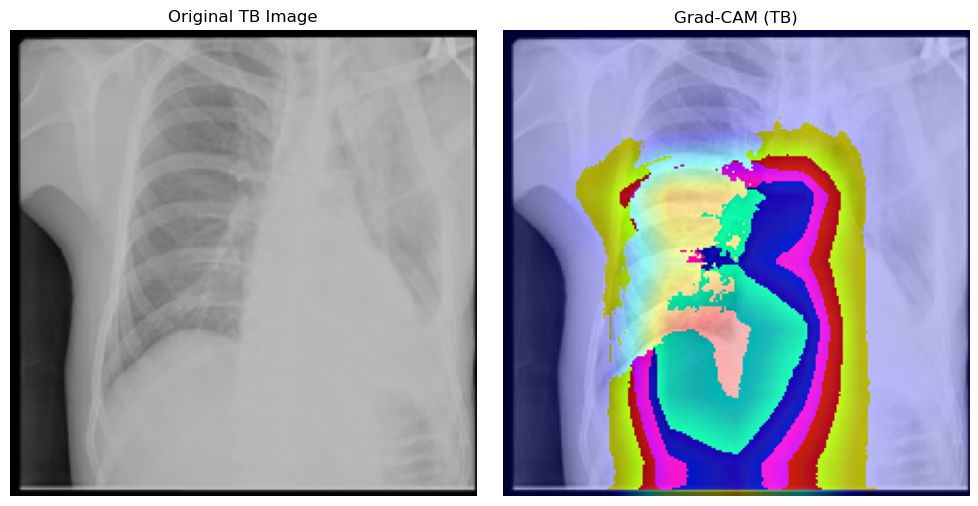

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model

# ======================
# Load Best TB Model
# ======================
tb_gradcam_model_path = "ResNet50_tb_model_best.h5"
tb_model_best = load_model(tb_gradcam_model_path, compile=False)

tb_model_best.summary()

LAST_CONV_LAYER_NAME = "conv5_block3_out"  # from summary

# ======================
# Grad-CAM function
# ======================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name=LAST_CONV_LAYER_NAME):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# ======================
# Pick a TB test image
# ======================
sample_class = "TUBERCULOSIS"  # or "NORMAL"
sample_path = os.path.join(test_dir, sample_class,
                           os.listdir(os.path.join(test_dir, sample_class))[0])
print("Using test image:", sample_path)

img = tf.keras.preprocessing.image.load_img(sample_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
input_tensor = np.expand_dims(img_array, axis=0)

# ======================
# Generate heatmap
# ======================
heatmap = make_gradcam_heatmap(input_tensor, tb_model_best)

heatmap_resized = cv2.resize(heatmap, IMG_SIZE)
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

superimposed = heatmap_color * 0.4 + (img_array * 255).astype("uint8")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original TB Image")
plt.imshow(img_array)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM (TB)")
plt.imshow(superimposed.astype("uint8"))
plt.axis("off")
plt.tight_layout()
plt.show()
